# Non-Negative Matrix Factorization applications.

In this notebook we try to use our implementations of Non-Negative Matrix Factorization for two purposes :
    - recommend movies based on users ratings of different movies
    - faces recognition

The two implementations of NMF try respectively to minimize  :
    - Kullback-Leibler divergence (see kul_mul.py)
    - Frobenius distance (see fro_mul.py)

In [1]:
import numpy as np
import scipy.io as sio
import numpy as np
from kul_mul import *
from fro_mul import *
from monitor import *
import pandas as pd

# Application of Non-Negative Matrix Factorization to Recommender System

The dataset studied here is taken from https://grouplens.org/datasets/movielens/ . It is a dataset composed of 1M ratings of 4000 movies by 6000 users.
There are actually three datasets :
    - the ratings containing the UserID, the MovieID and the rating of each user for that movie.
    - the users list containing information on each user, that we don't use here.
    - the movies list containing information on each movie (it relates the movie ID to more general information).
    

In [2]:
ratings_list = [i.strip().split("::") for i in open('./ml-1m/ratings.dat', 'r').readlines()]
users_list = [i.strip().split("::") for i in open('./ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('./ml-1m/movies.dat', 'r', errors='ignore').readlines()]

In [3]:
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [4]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
print(ratings_df.shape)

(1000209, 4)


In [6]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
print(movies_df.shape)

(3883, 3)


In the next cell, we build a Dataframe containing :
    - UserID's as rows
    - MovieID's as columns
so that the cell $df[i,j]$ contains the rating of user $i$ for movie $j$.
When user $i$ has not rated movie j, we put a 0 in $df[i,j]$

In [8]:
R_df = ratings_df.pivot(index = 'UserID', columns ='MovieID', values = 'Rating').fillna(0)
R_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order that each user has the same distribution for the ratings (at least the same mean, we need to rescale them)

In [12]:
nrows, ncols = R_centered.shape
print(R_centered.shape)

(6040, 3706)


## Factorization

In [21]:
niter = 100
r = 200
R_array = np.array(R_centered)
froNMF = FrobeniusNMF(V=R_array, r=r)
froNMF.train(niter=niter, verbose=True)
W, H = froNMF.W, froNMF.H

Iter n° 0
Iter n° 10
Iter n° 20
Iter n° 30
Iter n° 40
Iter n° 50
Iter n° 60
Iter n° 70
Iter n° 80
Iter n° 90


In [22]:
print('Shape of W : ', W.shape)
print('Shape of H : ',H.shape)

Shape of W :  (6040, 200)
Shape of H :  (200, 3706)


We are now able to get all the users' predicted ratings :

In [23]:
predicted_ratings = W @ H
predicted_ratings = pd.DataFrame(predicted_ratings, columns=R_df.columns)

In [24]:
predicted_ratings.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.297006,0.366646,0.010961,0.000061,0.085501,0.087364,0.023754,0.046200,2.257510e-10,0.000484,...,0.000306,1.462597e-03,0.003202,0.000001,2.121186e-07,0.007537,0.001144,0.001598,2.502152e-05,0.005444
1,0.248515,0.488034,0.092267,0.024513,0.075321,0.717282,0.108451,0.012228,4.627286e-02,1.745517,...,0.002505,1.000690e-03,0.002194,0.025018,4.557197e-02,0.048754,0.078007,0.022777,9.656424e-06,0.064113
2,1.752491,0.942908,0.176351,0.000749,0.000095,0.151770,0.003188,0.025463,4.245084e-07,1.693241,...,0.000331,1.268685e-09,0.006013,0.000999,3.336633e-02,0.035097,0.005385,0.000024,5.973573e-09,0.000685
3,0.156802,0.179894,0.055766,0.000201,0.000072,0.208327,0.000158,0.000666,6.476793e-08,0.002050,...,0.015361,1.692622e-03,0.007131,0.004174,1.124979e-02,0.001058,0.079317,0.015840,1.733951e-02,0.035638
4,0.895273,0.027425,0.184730,0.007012,0.000457,1.579379,0.042101,0.008202,5.915768e-08,0.169644,...,0.046947,1.961382e-03,0.001908,0.012518,4.318543e-02,0.083905,0.100084,0.025670,8.633492e-02,0.045284


In [25]:
np.linalg.norm(W@H - R_array)

2500.0901692382827

In [26]:
def recommend(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5) :
    user_row_number = userID - 1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    sorted_movie_id = sorted_user_predictions
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'MovieID', right_on = 'MovieID').
                     sort_values(['Rating'], ascending=False)
                 )
    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['MovieID'].isin(user_full['MovieID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'MovieID',
               right_on = 'MovieID').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [28]:
user_full, recommendations = recommend(predicted_ratings, userID=837, movies_df=movies_df, original_ratings_df=ratings_df)

User 837 has already rated 69 movies.
Recommending the highest 5 predicted ratings movies not already rated.


In [29]:
recommendations

,MovieID,Title,Genres
596,608,Fargo (1996),Crime|Drama|Thriller
1235,1284,"Big Sleep, The (1946)",Film-Noir|Mystery
1196,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller
581,593,"Silence of the Lambs, The (1991)",Drama|Thriller
3207,3334,Key Largo (1948),Crime|Drama|Film-Noir|Thriller


In [30]:
user_full

,UserID,MovieID,Rating,Timestamp,Title,Genres
36,837,858,5,975360036,"Godfather, The (1972)",Action|Crime|Drama
35,837,1387,5,975360036,Jaws (1975),Action|Horror
65,837,2028,5,975360089,Saving Private Ryan (1998),Action|Drama|War
63,837,1221,5,975360036,"Godfather: Part II, The (1974)",Action|Crime|Drama
11,837,913,5,975359921,"Maltese Falcon, The (1941)",Film-Noir|Mystery
20,837,3417,5,975360893,"Crimson Pirate, The (1952)",Adventure|Comedy|Sci-Fi
34,837,2186,4,975359955,Strangers on a Train (1951),Film-Noir|Thriller
55,837,2791,4,975360893,Airplane! (1980),Comedy
31,837,1188,4,975360920,Strictly Ballroom (1992),Comedy|Romance
28,837,1304,4,975360058,Butch Cassidy and the Sundance Kid (1969),Action|Comedy|Western


# Application of Non-Negative Matrix Factorization to Face Recognition

In [32]:
import scipy.io as sio
import scipy.misc as smp
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

The dataset we use here is composed of 10 different face pictures of 40 different people.
The idea here is to build a classifier based on Non Negative Matrix factorization for face recognition.


(112, 92, 3)


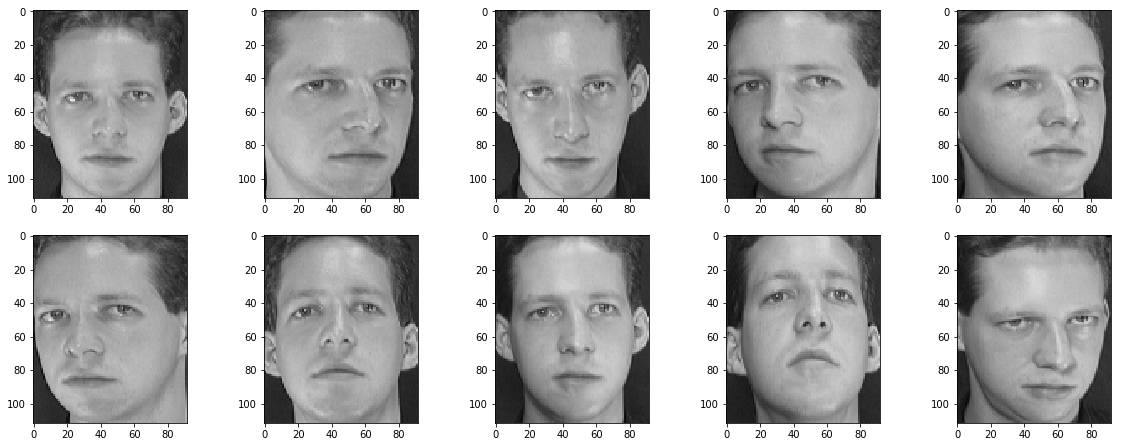

In [47]:
# Let's see some images from the dataset
fig = plt.figure(figsize=(20, 20))
for i in range(1, 11) :
    img = cv2.imread('./orl_faces/s1/{}.pgm'.format(i))
    fig.add_subplot(5, 5, i)
    plt.imshow(img)
print(img.shape)

In [55]:
'''We first build a train and test set : we select 7 pictures for each individual for the train set aand keep the 
3 others for the test set. We keep in memory a number for each picture which represent the subject'''

def build_sets(path, new_shape = (32, 32), train_size = 7):
    x_tr = np.zeros((train_size*40, new_shape[0]*new_shape[1]))
    y_tr = []
    x_te = np.zeros(((10-train_size)*40, new_shape[0]*new_shape[1]))
    y_te = []
    ind_tr = 0
    ind_te = 0
    for i in range(1, 41) :
        for j in range(1, 11) :
            img = cv2.imread(path + '/orl_faces/s{}/{}.pgm'.format(i, j))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, new_shape)
            img = img.reshape((new_shape[0]*new_shape[1]))
            if j <= train_size :
                x_tr[ind_tr, :] = img
                y_tr.append(i)
                ind_tr += 1
            else :
                x_te[ind_te, :] = img
                y_te.append(i)
                ind_te += 1
    return x_tr, x_te, np.array(y_tr), np.array(y_te)

In [110]:
'''We now have 4 datasets :
    - x_tr/te where rows number i correspond to a 32*32 image of a patient
    - y_tr where the ith element answers the question : which face is it'''

from sklearn.utils import shuffle

x_tr, x_te, y_tr, y_te = build_sets(path='./')
x_tr, y_tr = shuffle(x_tr, y_tr)
x_te, y_te = shuffle(x_te, y_te)

(280, 1024)


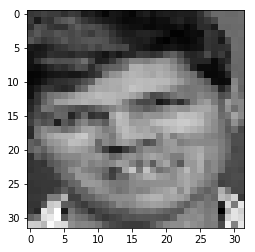

In [111]:
print(x_tr.shape)
plt.imshow(x_tr[0].reshape((32, 32)), 'gray')

In [137]:
'''We are now ready to proceed to the NMF decomposition of x_tr'''
niter = 100
froNMF = FrobeniusNMF(V=x_tr, r=20)
froNMF.train(niter = 300, verbose = True)

Iter n° 0
Iter n° 10
Iter n° 20
Iter n° 30
Iter n° 40
Iter n° 50
Iter n° 60
Iter n° 70
Iter n° 80
Iter n° 90
Iter n° 100
Iter n° 110
Iter n° 120
Iter n° 130
Iter n° 140
Iter n° 150
Iter n° 160
Iter n° 170
Iter n° 180
Iter n° 190
Iter n° 200
Iter n° 210
Iter n° 220
Iter n° 230
Iter n° 240
Iter n° 250
Iter n° 260
Iter n° 270
Iter n° 280
Iter n° 290


In [163]:
W_tr, H_tr = froNMF.W, froNMF.H
np.save(arr=W_tr, file='./W_fro_faces')
np.save(arr=H_tr, file='./H_fro_faces')

In [164]:
def build_W_te(h_tr, x_te) :
    h_tr_ = h_tr.copy()
    h_tr_pinv = np.linalg.pinv(h_tr_)
    w_te = x_te @ h_tr_pinv
    return w_te

In [165]:
W_te = build_W_te(H_tr, x_te)

In [166]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(W_tr, y_tr)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [167]:
print(clf.predict(W_te))

[38  7 25 22 14 12  2  9 34 19 38 36 25 36  1 21 27 31 20 25 33 15 37 34
 37 12 32 12 11 23  4 30 18 24 33  7  3 26  5 22  1 22 35 30 36 39 18 40
  9 31  6 39  8 18 35 37 33 17 20 29 26 23 17 38 11 26 20 15 10  6 38 24
 13  1 14 19  3 16 21 39  4  6  3 27 34 17 17  8 31 11  4 16  7 29 40 32
  9 30  1 37  8 40 15 28  5 23 35 14 27 13 32  2 21 29 14 10 40 24 13  2]


In [169]:
print(clf.score(W_te, y_te))

0.95


## Comparison of NMF with a PCA

In [170]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 20)
x_tr_pca = pca.fit_transform(x_tr)
x_te_pca = pca.transform(x_te)

In [171]:
print(x_tr_pca.shape)

(280, 20)


In [172]:
clf_pca = KNeighborsClassifier(n_neighbors = 1)
clf_pca.fit(x_tr_pca, y_tr)
print('Score with PCA : ', clf_pca.score(x_te_pca, y_te))

Score with PCA :  0.95


In [191]:
def plot_results(ranks = [5, 10, 15, 20, 30, 50]) :
    pca_results = []
    nmf_results = []
    for r in ranks :
        niter = 200
        froNMF = FrobeniusNMF(V=x_tr, r=r)
        froNMF.train(niter = niter, verbose = False)
        W_tr, H_tr = froNMF.W, froNMF.H
        W_te = build_W_te(h_tr=H_tr, x_te=x_te)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(W_tr, y_tr)
        nmf_results.append(clf.score(W_te, y_te))
        pca = PCA(n_components = r)
        x_tr_pca = pca.fit_transform(x_tr)
        x_te_pca = pca.transform(x_te)
        clf.fit(x_tr_pca, y_tr)
        pca_results.append(clf.score(x_te_pca, y_te))
    plt.plot(ranks, nmf_results, color = 'r', label = 'NMF')
    plt.plot(ranks, pca_results, color = 'g', label = 'PCA')
    plt.legend()
    plt.title('Comparison between PCA and NMF for faces recognition')
    plt.show()
    return

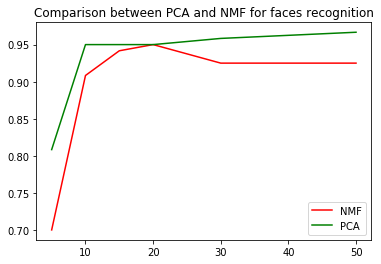

In [192]:
plot_results()